# Winning the Game: Analyzing NBA Player Performance 

### CMSC 320, Spring 2024 Final Tutorial
### Justin Shim, Terrence Chungong, Ben Aharon



## Introduction

The NBA, or National Basketball Association, is one of the most popular and competitive professional basketball leagues in the world. Founded in 1946, the NBA has grown to include 30 teams across North America, attracting millions of fans globally. The league is renowned for its high level of play, featuring some of the most talented and well-known athletes in sports history. 

Basketball organizations are worth billions of dollars which means that there is pressure on leadership to lead them in the right direction. With the increase in availability of data, the applications of data science can help leaders of professional basketball organizations gain insights on how to get the most out of their players. Exploring NBA data can also help aspiring basketball players understand how they can gain a competitive advantage in the sport. Exploring data and applying Machine Learning algorithms can also help NBA coaches predict the success of prospective draft picks, thus allowing them to bring in the highest caliber talent.

Making optimal decisions in a hyper-competitive league such as the NBA requires a deep dive into data. This project will make that task easier for the decision makers.

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from nba_api.stats.static import teams
from nba_api.stats.endpoints import leaguedashplayerstats, commonplayerinfo, commonteamroster
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import numpy as np
from sklearn.decomposition import PCA
from IPython.display import Image
import os
# Independent variables: Points, Rebounds, Assists, Steals, Blocks, Field Goal Attempts, Free Throw Attempts, Turnovers
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

headers = {
'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36',
}

## Data Collection

At this stage of the Data Science life cycle, we will begin by storing the data that we will use throughout the project in a pandas dataframe. We will be using the nba_stats library which provides an easy to use interface with the official NBA API. 

We will store the 2023-24 season stats of every NBA player in our dataframe and rename columns for readability.

In [2]:
player_stats = leaguedashplayerstats.LeagueDashPlayerStats(season='2023-24').get_data_frames()[0]
print(player_stats.columns)

# Select relevant columns from the player stats
stats_columns = [
    'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ABBREVIATION', 'GP', 'PTS', 'FGM', 'FGA', 'FG_PCT', 
    'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'AST', 'TOV',
       'W', 'L', 'W_PCT', 'MIN', 'OREB', 'DREB', 'REB',
     'STL', 'BLK', 'AGE',
       'W_RANK', 'L_RANK', 'W_PCT_RANK', 'MIN_RANK', 'FGM_RANK', 'FGA_RANK',
       'FG_PCT_RANK', 'FG3M_RANK', 'FG3A_RANK', 'FG3_PCT_RANK', 'FTM_RANK',
       'FTA_RANK', 'FT_PCT_RANK', 'OREB_RANK', 'DREB_RANK', 'REB_RANK',
       'AST_RANK', 'STL_RANK', 'BLK_RANK',  'PTS_RANK'
]
player_stats = player_stats[stats_columns]

player_stats.columns = [
    'Player ID', 'Player', 'Team', 'Games Played', 'PTS', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 
    'FTM', 'FTA', 'FT%', 'AST', 'TO',  'W', 'L', 'W_PCT', 'MIN', 'OREB', 'DREB', 'REB',
     'STL', 'BLK', 'AGE',
       'W_RANK', 'L_RANK', 'W_PCT_RANK', 'MIN_RANK', 'FGM_RANK', 'FGA_RANK',
       'FG_PCT_RANK', 'FG3M_RANK', 'FG3A_RANK', 'FG3_PCT_RANK', 'FTM_RANK',
       'FTA_RANK', 'FT_PCT_RANK', 'OREB_RANK', 'DREB_RANK', 'REB_RANK',
       'AST_RANK', 'STL_RANK', 'BLK_RANK',  'PTS_RANK' 
]

player_stats.set_index('Player', inplace=True)
player_stats

Index(['PLAYER_ID', 'PLAYER_NAME', 'NICKNAME', 'TEAM_ID', 'TEAM_ABBREVIATION',
       'AGE', 'GP', 'W', 'L', 'W_PCT', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
       'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
       'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS',
       'NBA_FANTASY_PTS', 'DD2', 'TD3', 'WNBA_FANTASY_PTS', 'GP_RANK',
       'W_RANK', 'L_RANK', 'W_PCT_RANK', 'MIN_RANK', 'FGM_RANK', 'FGA_RANK',
       'FG_PCT_RANK', 'FG3M_RANK', 'FG3A_RANK', 'FG3_PCT_RANK', 'FTM_RANK',
       'FTA_RANK', 'FT_PCT_RANK', 'OREB_RANK', 'DREB_RANK', 'REB_RANK',
       'AST_RANK', 'TOV_RANK', 'STL_RANK', 'BLK_RANK', 'BLKA_RANK', 'PF_RANK',
       'PFD_RANK', 'PTS_RANK', 'PLUS_MINUS_RANK', 'NBA_FANTASY_PTS_RANK',
       'DD2_RANK', 'TD3_RANK', 'WNBA_FANTASY_PTS_RANK'],
      dtype='object')


,Player ID,Team,Games Played,PTS,FGM,FGA,FG%,3PM,3PA,3P%,...,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,STL_RANK,BLK_RANK,PTS_RANK
Player,,,,,,,,,,,,,,,,,,,,,
A.J. Lawson,1630639,DAL,42,136,54,121,0.446,13,50,0.260,...,382,374,445,389,407,408,414,386,428,385
AJ Green,1631260,MIL,56,252,83,196,0.423,69,169,0.408,...,372,388,54,424,366,381,373,398,410,313
AJ Griffin,1631100,ATL,20,48,18,62,0.290,10,39,0.256,...,487,493,1,507,463,475,488,509,451,450
Aaron Gordon,203932,DEN,73,1013,398,716,0.556,40,138,0.290,...,69,54,440,21,70,46,83,119,79,93
Aaron Holiday,1628988,HOU,78,514,186,417,0.446,84,217,0.387,...,217,247,37,318,299,310,157,194,370,216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zach LaVine,203897,CHI,25,487,170,376,0.452,59,169,0.349,...,163,176,108,436,262,299,225,312,331,225
Zavier Simpson,1630285,MEM,7,42,17,54,0.315,5,17,0.294,...,470,475,307,473,463,469,391,417,428,460
Zeke Nnaji,1630192,DEN,58,186,69,149,0.463,6,23,0.261,...,267,249,418,146,351,306,369,348,108,351


## Data Processing

In this phase of the Data Science Life cycle, we will add to our data frame and prepare the columns for analysis.

We will also need to append additional columns to our data frame so that we can do more analysis on the players. The cell below adds 5 new columns to the dataframe.

In [3]:
columns_to_add = ['HEIGHT', 'WEIGHT', 'EXP', 'SCHOOL', 'POSITION']
for col in columns_to_add:
    player_stats[col] = None

The data for these columns will come from another module within nba_stats api. 

In [4]:
team_ids = [(team['id'], '2023-24') for team in teams.get_teams()]
# Print the list of team IDs and names
for team_id, season_id in team_ids:
    roster = commonteamroster.CommonTeamRoster(team_id=team_id, season=season_id)
    roster_df = roster.get_data_frames()[0]

    for _, row in roster_df.iterrows():
        p_name = row['PLAYER']
        att_dict = {col:row[col] for col in columns_to_add}
        if p_name in player_stats.index:
            player_stats.loc[p_name, columns_to_add] = pd.Series(att_dict)

We're nearly done! We also need to perform mass operations on the dataframe to create new columns and convert the data types of other columns.

In [5]:
player_stats['PPG'] = player_stats['PTS'] / player_stats['Games Played']   # Points per game
player_stats['HEIGHT'] = player_stats['HEIGHT'].apply(lambda h: int(h.split('-')[0]) * 12 + int(h.split('-')[1]) if pd.notnull(h) else None)  # Convert to inches
player_stats['EXP'] = player_stats['EXP'].apply(lambda x: int(x) if x and x.isdigit() else -1)  # Convert to a digit
player_stats

,Player ID,Team,Games Played,PTS,FGM,FGA,FG%,3PM,3PA,3P%,...,AST_RANK,STL_RANK,BLK_RANK,PTS_RANK,HEIGHT,WEIGHT,EXP,SCHOOL,POSITION,PPG
Player,,,,,,,,,,,,,,,,,,,,,
A.J. Lawson,1630639,DAL,42,136,54,121,0.446,13,50,0.260,...,414,386,428,385,78.0,179,1,South Carolina,G,3.238095
AJ Green,1631260,MIL,56,252,83,196,0.423,69,169,0.408,...,373,398,410,313,76.0,190,1,Northern Iowa,G,4.500000
AJ Griffin,1631100,ATL,20,48,18,62,0.290,10,39,0.256,...,488,509,451,450,78.0,220,1,Duke,F,2.400000
Aaron Gordon,203932,DEN,73,1013,398,716,0.556,40,138,0.290,...,83,119,79,93,80.0,235,9,Arizona,F,13.876712
Aaron Holiday,1628988,HOU,78,514,186,417,0.446,84,217,0.387,...,157,194,370,216,72.0,185,5,UCLA,G,6.589744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zach LaVine,203897,CHI,25,487,170,376,0.452,59,169,0.349,...,225,312,331,225,77.0,200,9,UCLA,G,19.480000
Zavier Simpson,1630285,MEM,7,42,17,54,0.315,5,17,0.294,...,391,417,428,460,NaN,None,-1,None,None,6.000000
Zeke Nnaji,1630192,DEN,58,186,69,149,0.463,6,23,0.261,...,369,348,108,351,81.0,240,3,Arizona,F-C,3.206897


## Exploratory Analysis & Data Visualization


In this stage of the data science life cycle, we will visualize the data to improve our understanding of it. Alongside this, we'll carry out statistical analyses to provide mathematical validation for any observed patterns. Essentially, we will be engaging in a more detailed examination of the data.

To carry this out, we will use both the Matplotlib(https://matplotlib.org/stable/index.html) and Seaborn(https://seaborn.pydata.org/api.html). You can learn more about each through the provided links.

As previously mentioned, the performance of individual players is essential to their teams' success. In this section, we will examine various statistics to determine what contributes to these players' effectiveness. 

To begin with, lets figure out which positions score the most points across all of the teams. 

In [6]:
average_pts_by_pos = player_stats.groupby('POSITION')['PPG'].mean()

The line of code above puts each row into its respective category based on the POSITION varible and aggregates the points per game data to get the mean.

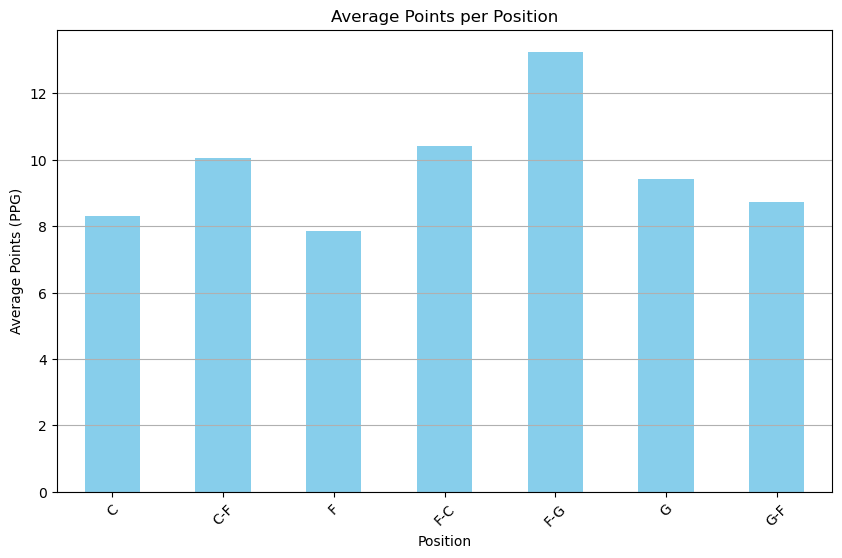

In [7]:
plt.figure(figsize=(10, 6))
average_pts_by_pos.plot(kind='bar', color='skyblue')
plt.title('Average Points per Position')
plt.xlabel('Position')
plt.ylabel('Average Points (PPG)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

It is clear that players at the Forward-Guard (F-G) position produce the most points for their teams. Some notable F-G's are Scottie Pippen (6ft 8in tall) Larry Bird (6ft 9in) and Julius Erving (6ft 7in). What do these players have in common you ask? They are all very tall! Could there be a linear relationship between the height of a player  and the number of points that he scores? There's only one way to find out: we will use a scatterplot of graph Points Per Game and Player Height. We will use quite a few scatter plots throughout the tutorial. Click here to learn more about scatterplots: https://en.wikipedia.org/wiki/Scatter_plot.

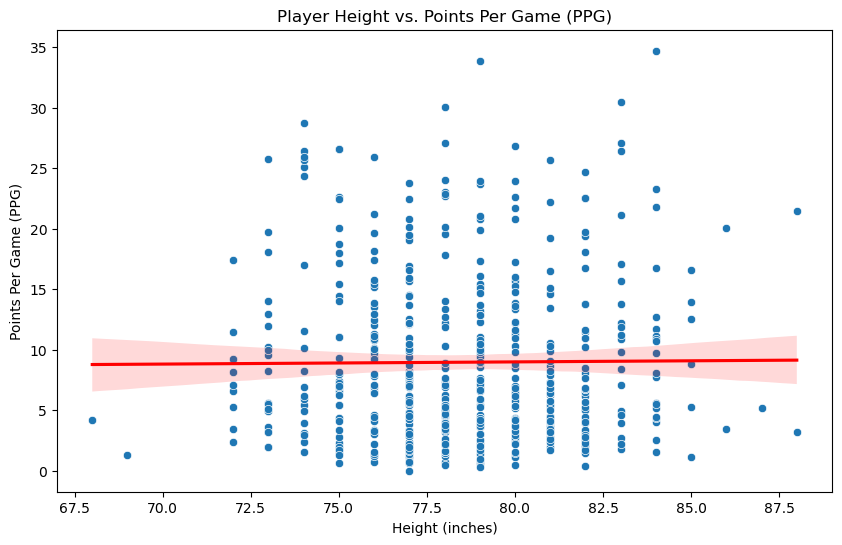

In [8]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='HEIGHT', y='PPG', data=player_stats)
sns.regplot(x='HEIGHT', y='PPG', data=player_stats, scatter=False, color='red')
plt.title('Player Height vs. Points Per Game (PPG)')
plt.xlabel('Height (inches)')
plt.ylabel('Points Per Game (PPG)')
plt.show()   

The flat regression line indicates that there is a weak correlation between height and points per game, if not none. It seems that players of all different heights score in many point ranges. Although we cannot conclude that a player being tall in height has any impact on their production on offense, let's figure out if there are other variables that have a strong correlation with points per game. 

Next we will plot a line graph of Average Points Per Game vs Age. To learn more about line graphs, click here: https://en.wikipedia.org/wiki/Line_graph.

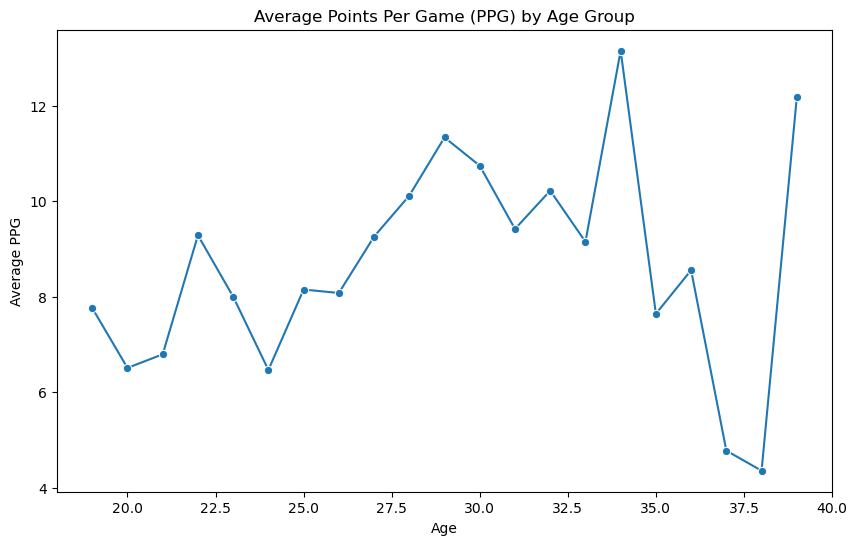

In [9]:
average_ppg_by_age = player_stats.groupby('AGE')['PPG'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(x='AGE', y='PPG', data=average_ppg_by_age, marker='o')
plt.title('Average Points Per Game (PPG) by Age Group')
plt.xlabel('Age')
plt.ylabel('Average PPG')
plt.show()

The chart shows that NBA players generally improve their scoring ability until they reach their early 30s, where they achieve peak performance with the highest average PPG around age 32. After this peak, there is a gradual decline in scoring with increasing age. However, there is notable variability throughout, with some late-career spikes, likely due to a few exceptional older players.

To be sure that the average PPG at age 40 is sure to an outlier, let's make a histogram that shows us the age distribution of playeers in the NBA.

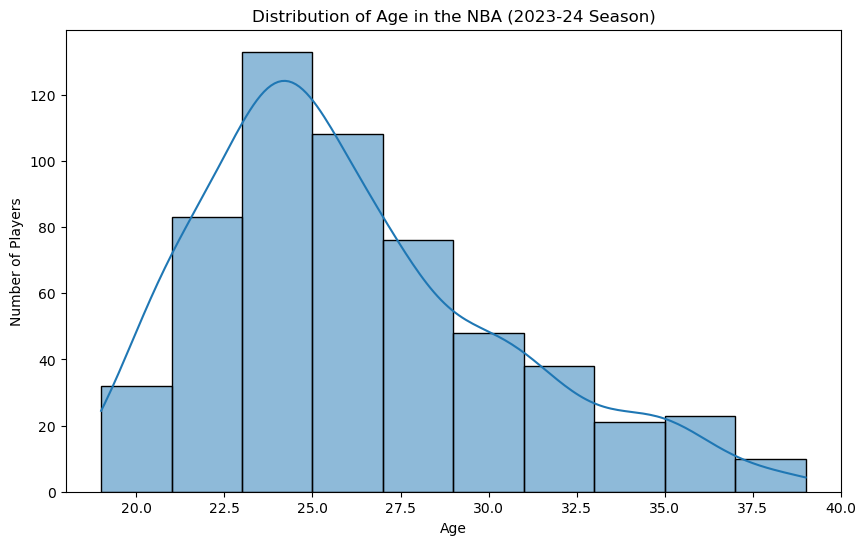

In [10]:
plt.figure(figsize=(10, 6))
sns.histplot(player_stats['AGE'], bins=10, kde=True)
plt.title('Distribution of Age in the NBA (2023-24 Season)')
plt.xlabel('Age')
plt.ylabel('Number of Players')
plt.show()

The histogram shows that most NBA players are between ages 22-25, with less than 20 players over the age of 37. Let's dive deeper by filtering our data frame to contain ony players older than 37 to see who this super star player happens to be.

In [11]:
player_stats.loc[player_stats['AGE'] > 37]

,Player ID,Team,Games Played,PTS,FGM,FGA,FG%,3PM,3PA,3P%,...,AST_RANK,STL_RANK,BLK_RANK,PTS_RANK,HEIGHT,WEIGHT,EXP,SCHOOL,POSITION,PPG
Player,,,,,,,,,,,,,,,,,,,,,
Chris Paul,101108,GSW,58,533,206,467,0.441,78,210,0.371,...,28,66,370,204,72.0,175,18,Wake Forest,G,9.189655
Garrett Temple,202066,TOR,27,88,29,78,0.372,12,40,0.300,...,380,367,428,418,77.0,195,13,Louisiana State,G-F,3.259259
Kyle Lowry,200768,PHI,60,487,163,377,0.432,98,250,0.392,...,87,108,202,225,72.0,196,17,Villanova,G,8.116667
LeBron James,2544,LAL,71,1822,685,1269,0.540,149,363,0.410,...,6,20,108,14,81.0,250,20,St. Vincent-St. Mary HS (OH),F,25.661972
P.J. Tucker,200782,LAC,31,52,18,50,0.360,13,35,0.371,...,430,341,343,445,77.0,245,12,Texas,F,1.677419
Taj Gibson,201959,DET,20,34,15,37,0.405,2,10,0.200,...,451,471,343,474,81.0,232,14,Southern California,F,1.700000


Unsurprisingly, this superstar is LeBron James, one of the greatest NBA players of all time. LeBron's exceptional performance skews the mean points per game (PPG) for players over the age of 37, as his PPG is significantly higher than that of his peers in the league.

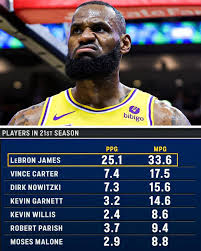

In [12]:
Image(filename='year21_ppg_lbj.jpeg')

Typically, the top performing players in the league come from powerhouse Division 1 basketball schools. We would like to see if this is reflected in the data to figre out where the highest performing NBA players were before they were drafted - whether it was a college or an overseas team. To do that, we will create a bar graph which shows us that. 

In [13]:
school_stats = player_stats.groupby('SCHOOL').agg(
    Total_Points=pd.NamedAgg(column='PPG', aggfunc='sum'),
    Player_Count=pd.NamedAgg(column='Player ID', aggfunc='count')
).reset_index()

First we create a new data frame named school_stats where we group players (entries) in our original dataframe by their school. The Total_points column will contain the sum of ppg of each player at the corresponding school. The Player_count column simply counts the number of players at each school.

In [14]:
school_stats['Average Points Per Player'] = school_stats['Total_Points'] / school_stats['Player_Count']

This line gets the average of each player and stores it in a new column.

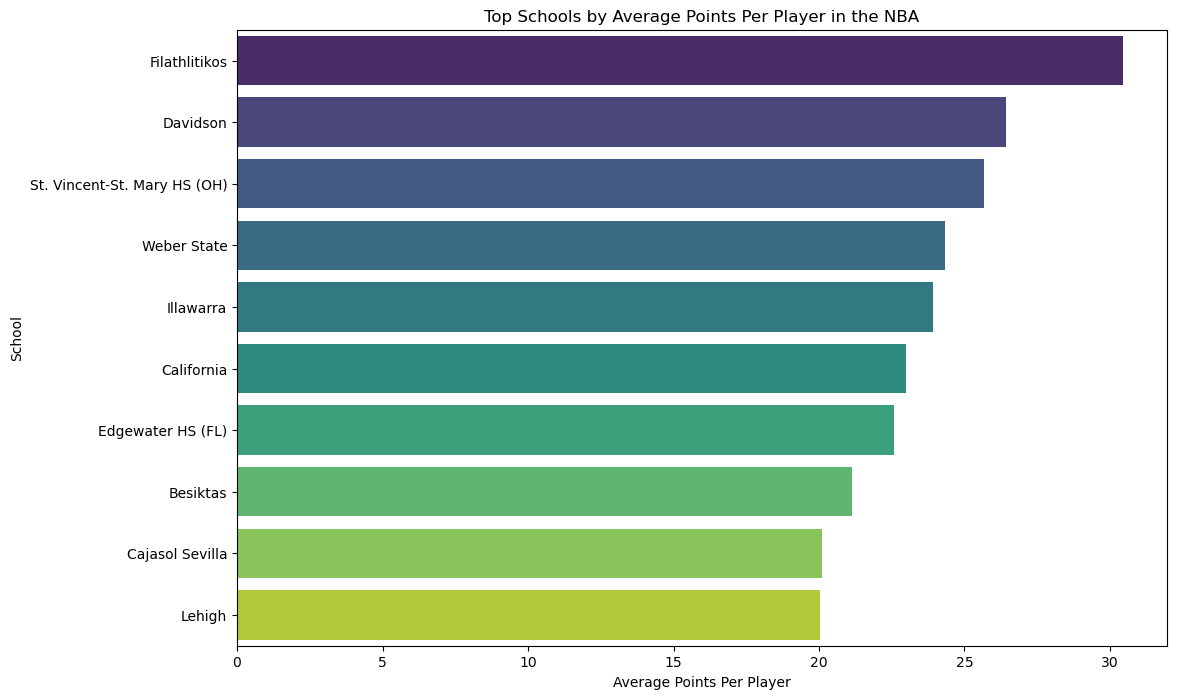

In [15]:
# Sort the schools by average points per player in descending order
top_schools = school_stats.sort_values(by='Average Points Per Player', ascending=False).head(10)

# Plotting the top schools by average points per player
plt.figure(figsize=(12, 8))
sns.barplot(x='Average Points Per Player', y='SCHOOL', data=top_schools, palette='viridis')
plt.title('Top Schools by Average Points Per Player in the NBA')
plt.xlabel('Average Points Per Player')
plt.ylabel('School')
plt.show()

Surprisingly, the above graph shows that players from non-Division 1 powerhouse schools are thriving in the NBA, with three of the top ten coming from overseas professional teams (Cajasol, Besiktas, Illawarra, Filathlitikos). Hopefully, this data can inspire aspiring NBA players, showing them that there are alternative paths to entering the NBA and succeeding.

Another factor that may contributes to a players' offensive productivity is the number of years of experience (YOE) they have in the NBA. Let's plot PPG over YOE for each player using data from the past season using a scatter plot.

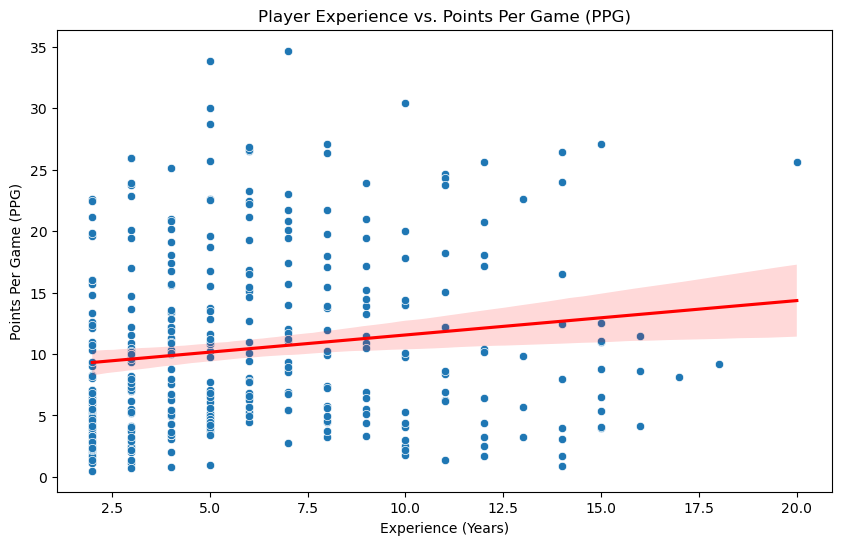

In [16]:
filtered_df = player_stats.loc[player_stats['EXP'] > 1]
plt.figure(figsize=(10, 6))
sns.scatterplot(x='EXP', y='PPG', data=filtered_df)
sns.regplot(x='EXP', y='PPG', data=filtered_df, scatter=False, color='red')
plt.title('Player Experience vs. Points Per Game (PPG)')
plt.xlabel('Experience (Years)')
plt.ylabel('Points Per Game (PPG)')
plt.show()

We're onto something here... The regression line is not entirely flat; it is pointing upwards. This indicates a trend where more experienced NBA players tend to score more than less experienced players.

Lets also plot total season points over minutes played to figure out whether paying more minutes leads to more points scored overall.

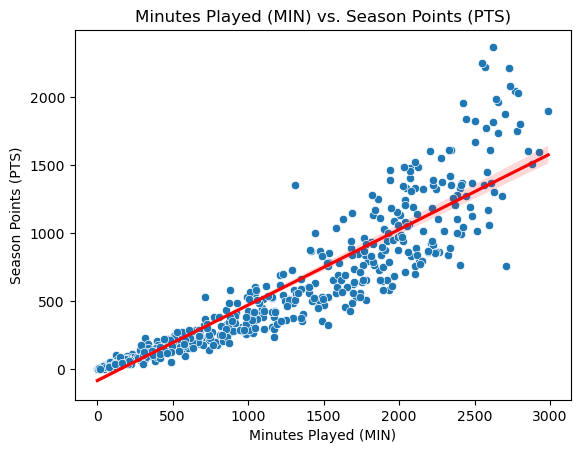

In [17]:
sns.scatterplot(x='MIN', y='PTS', data=player_stats)
sns.regplot(x='MIN', y='PTS', data=player_stats, scatter=False, color='red')
plt.title('Minutes Played (MIN) vs. Season Points (PTS)')
plt.xlabel('Minutes Played (MIN)')
plt.ylabel('Season Points (PTS)')
plt.show()


It's easy to see from this graph that amount of playing time a player gets certainly impacts how much they score. We can conclude from the regression line that there is a linear relationship between minutes played and points scored where the more a player plays, the more points they score.

We want to predict player success. In the NBA, players are often judged not only by their individual stats but also by their ability to lead their team to victories. Our data can provide insight into how frequently high-scoring players are members of teams that win a lot of games.

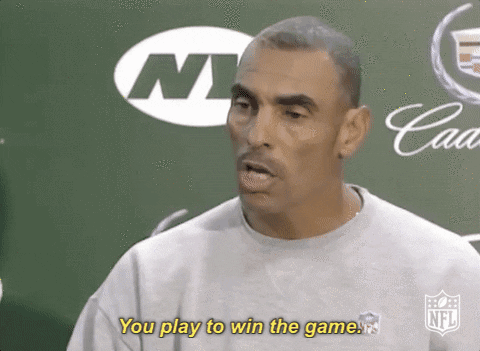

In [18]:
Image(filename='ptwtg.gif')

To explore this relationship, we will make another scatter plot, this time, plotting Players' point rankings vs their team's number of wins.

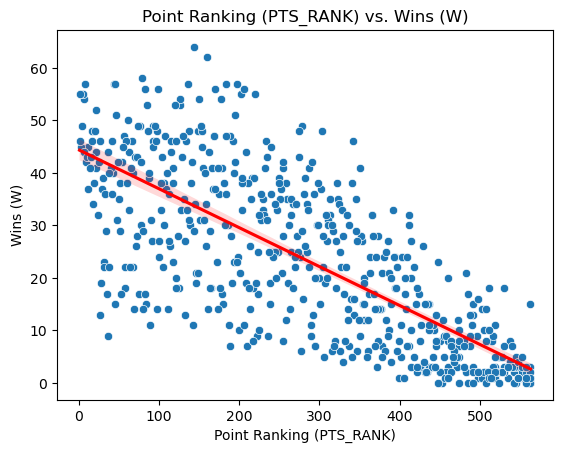

In [19]:
sns.scatterplot(x='PTS_RANK', y='W', data=player_stats)
sns.regplot(x='PTS_RANK', y='W', data=player_stats, scatter=False, color='red')
plt.title('Point Ranking (PTS_RANK) vs. Wins (W)')
plt.xlabel('Point Ranking (PTS_RANK)')
plt.ylabel('Wins (W)')
plt.show()

In this case, player rankings go from low to high in ascending order with 1 being the highest possible ranking.

The regression line reveals that there is a negative correlation between Point Ranking and Wins. As the Point Ranking increases (indicating lower performance in scoring), the number of Wins decreases. Teams with higher Point Rankings tend to have more wins, often ranging between 30 to 60 wins while teams with lower Point Rankings tend to have fewer wins, ranging between 0 to 30 wins.

There is plenty of scatter around the regression line, which means that there is much variability.
This variability suggests that while scoring is a factor in determining wins, other factors also play a role such as defense and rebounds.

We have delved into points per game and what might influence that statistic. However, a players offensive stats such as their PPG is not the only metric we can use to determine how skilled they are. In the basketball world, it is often said that defense wins championships. Therefore, let's explore relationships and trends embedded in defensive data.

Grabbing defensive rebounds and blocking shots both require great timing, leaping ability, and athleticism. A player who excels in these areas is a valuable asset to the team's defense. Since both skills demand similar physical attributes, it is reasonable to believe that players who block many shots also tend to grab many rebounds.

To figure out whether this is true, let's start off our defensive stat analytics by creating a scatter plot of Defensive Rebounds versus Blocks. 

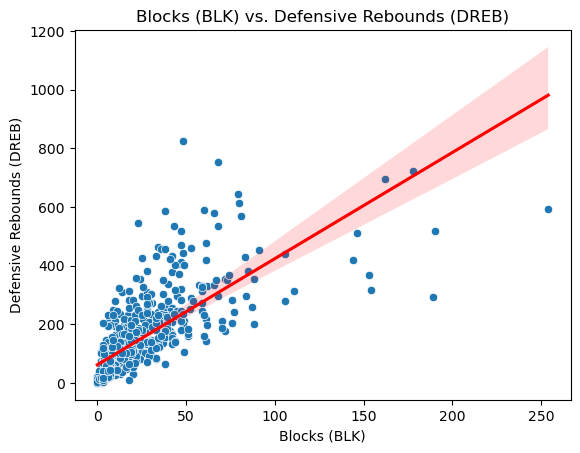

In [20]:
sns.scatterplot(x='BLK', y='DREB', data=player_stats)
sns.regplot(x='BLK', y='DREB', data=player_stats, scatter=False, color='red')
plt.title('Blocks (BLK) vs. Defensive Rebounds (DREB)')
plt.xlabel('Blocks (BLK)')
plt.ylabel('Defensive Rebounds (DREB)')
plt.show()


The points on the scatter plot show that very few players accumulated more than 150 blocks and more than 700 rebounds. The data reveals that most players end with under 600 defensive rebounds and under 100 blocks.

The regression line on this scatter plot suggests that there is a trend in the data in which players who block more shots also tend to grab more defensive rebounds. This may be due to the previously stated fact that each action (blocking and rebounding) demands the same thing from the players physically.

The number of steals that a player has accumilated is also a useful metric for evaluating a player's defense. To explore the relationships between multiple variables (defensive metrics), we can use a pair plot from the seaborn library.

In [21]:
numeric_columns = ['STL', 'BLK', 'DREB']
player_stats_cleaned = player_stats.dropna(subset=numeric_columns)

Here we have dropped all columns that are Null.

/Users/justinshim/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


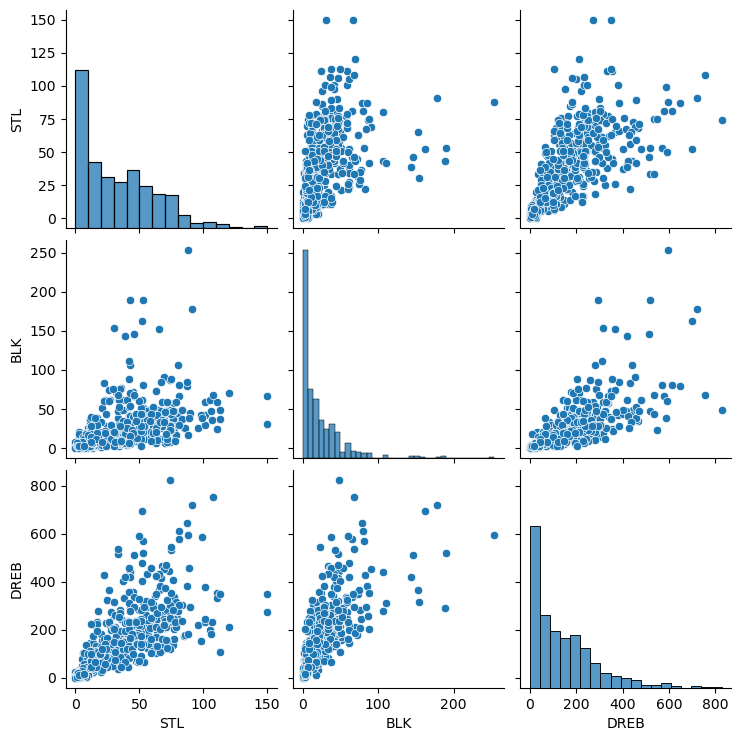

In [22]:
sns.pairplot(player_stats_cleaned[numeric_columns])
plt.show()

Wonderful! Now we can compare multiple metrics against each other with one plotting function. Pair plot is truly powerful. To learn more about Pair plots click here: (https://seaborn.pydata.org/generated/seaborn.pairplot.html)

Great offensive players in the NBA are often accused of slacking on defense to exert their energy on offense. Let's analyze steals and scoring data to determine if this is actually true. Again, we will use pair plot for this task and compare each metric with a players minutes played as well.

/Users/justinshim/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


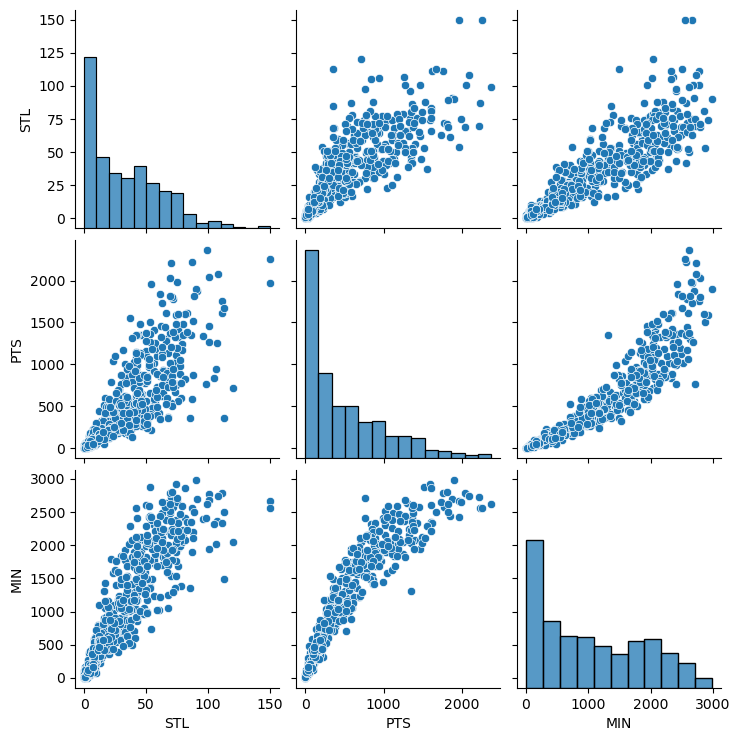

In [23]:
numeric_columns = ['STL', 'PTS', 'MIN']
player_stats_cleaned = player_stats.dropna(subset=numeric_columns)
sns.pairplot(player_stats_cleaned[numeric_columns])
plt.show()

Once again, our data has has provided us with data that is easy to miss by simply watching basketball alone. The middle left plot actually shows a trend in which high scoring players also tend to get many steals. There is some variance that tells us that that is not always the case, but there is certainly a positive correlation between points and steals.

## Model: Analysis, Hypothesis Testing, Machine Learning

During this phase of the Data Lifecycle, we will perform various modeling techniques in efforts of making predictions using our data. For example, we can use Linear regression to predict the number of points per game a player may score given their other stats.

The machine learning algorithm is the method or technique used to learn patterns from the training data and make predictions on new, unseen data. We will demonstrate its strengths through a scenario where we can make predictions about a player's position given their NBA stats. 

First, we begin by loading and cleaning the data. 

In [24]:
valid_positions = ['C','C-F','F','F-C','F-G','G','G-F'] # Definitive Positions recognized by the NBA 
f_df = player_stats[player_stats['POSITION'].isin(valid_positions)].copy() # Filter the DataFrame - removing missing data

# Drop rows with missing values
f_df.dropna(inplace=True)

# Select features and target variable
features = ['HEIGHT', 'PTS', 'FG%', '3P%','AST','STL','TO']

target = 'POSITION'
X = f_df[features]
y = f_df[target]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

For our purposes, we will use a Support Vector Machine (SVM) algorithm because they are well-suited for classification tasks. Since our case involves multiple features, SVM is a good choice because it is particularly effective in high-dimensional space.

In [25]:
# Initialize and train the model
model = SVC(kernel='rbf', class_weight='balanced', random_state=42)
model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           C       0.00      0.00      0.00         1
         C-F       0.33      0.50      0.40         2
           F       0.83      0.38      0.53        13
         F-C       0.33      0.50      0.40         2
         F-G       0.00      0.00      0.00         1
           G       0.80      0.67      0.73         6
         G-F       0.25      0.50      0.33         2

    accuracy                           0.44        27
   macro avg       0.36      0.36      0.34        27
weighted avg       0.65      0.44      0.50        27



The model performs best for the "G" (Guard) position with relatively high precision and recall.
The model struggles significantly with the "C" (Center) and "F-G" (Forward-Guard) positions, predicting no instances correctly.
The macro and weighted averages show that while the precision is somewhat decent, the recall is lower, which means that the model  fails to correctly identify the true positives.
In the future, we will extend this model by training it using data from more NBA seasons to improve accuracy.

Once you have a trained model, you can use it to predict new, unseen data

In [26]:
# Example new player data
features = ['HEIGHT', 'PTS', 'FG%', '3P%','AST','STL','TO']
new_player_data = [[78,136,.446,.26,20,10,14]]  # Example stats for a new player
new_player_df = pd.DataFrame(new_player_data, columns=features)
new_player_data_scaled = scaler.transform(new_player_df)
predicted_position = model.predict(new_player_data_scaled)
print(predicted_position)

['F']


This indicates that if a player is 6 foot 6 inches, scored 136 points, a 44.6% FG rate, a 26% 3-Point rate, 20 assists, 10 steals, and 14 turnovers, the player likely plays the Forward position for his team. 


Let's do another example.

This time, we will use historical player stats to predict a player's performance for an upcoming season. Let's do it! 

In [27]:
# To measure a player's performance, we will use a metric called Player Efficiency Rating (PER)

# Calculate Player Efficiency Rating (PER) for each player, populating dataframe 
player_stats['PER'] = (player_stats['PTS'] + (3/2) * player_stats['REB'] + (3/2) * player_stats['AST'] 
                       + (1/2) * player_stats['STL'] + (1/2) * player_stats['BLK'] 
                       - (3/2) * player_stats['FGA'] - (1/2) * player_stats['FTA'] 
                       - player_stats['TO']) / player_stats['MIN']

# Display the calculated PER for Lebron James
lbj = player_stats[player_stats['Player ID'] == 2544] # lbj player id
print(f"LeBron James' PER: {lbj['PER'].values[0]}")

# Fun Fact: You can run the following line to export the dataframe into a csv! You should only run it once. 
# player_stats.to_csv('output.csv')


LeBron James' PER: 0.4774964885069331


In [28]:
X = player_stats[['PTS', 'REB', 'AST', 'STL', 'BLK', 'FGA', 'FTA', 'TO']]
y = player_stats['PER']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the linear regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model using Mean Squared Error (MSE) and R-squared
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 0.03160409204041511
R-squared: 0.36890258524905495


This indicates that a player who scored 140 points, 50 rebounds, 20 assists, 10 steals, 3 blocks, 121 FG attempts, 23 free throw attempts, and 14 turnovers has a .2122 rating in the NBA.

This indicates that if a player has a height of 80 inches(6 foot 8), scores 15 points per game, makes 6 shots out of 12(shooting 50%), and shoots 35% on 3 pointers, he likely plays a Forward position. This prediction makes sense because typically Forwards are relatively tall (6ft 5-10in) and shoot lower 3 point averages than a guard would. With a model such as this one. An NBA coach can use a players previous data and predict what the best position would be for them to play in the NBA based on what positions similar players are in.

## Insight & Policy decision:

Through our analysis of NBA player performance data, we have uncovered valuable insights that teach us about various aspects that contribute to  player success and team performance. We found that certain player attributes, such as height, experience, and playing time, have interesting relationships with performance metrics like points per game (PPG) and defensive rebounds. 

Additionally, our machine learning model demonstrated promising capabilities in predicting player positions based on performance metrics.

In light of these insights, teams should prioritize scouting and recruiting players based on more than just traditional metrics like points scored or rebounds, but also attributes such as height, shooting efficiency, and defensive capabilities in order to have the most success with recruiting and player acquisitions.
